In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Manish Sir assignment /ship_fuel_efficiency.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
print("Rows, Columns:", df.shape)
display(df.head())
display(df.describe(include='all').T)
print("\nColumn dtypes:\n", df.dtypes)

Rows, Columns: (1440, 11)


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency,efficiency_class
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14,High Efficiency
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98,High Efficiency
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61,Medium Efficiency
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42,Medium Efficiency
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61,Medium Efficiency


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ship_id,1440,120,NG001,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ship_type,1440,4,Oil Service Boat,408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route_id,1440,4,Port Harcourt-Lagos,389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,1440,12,January,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance,1440.0,NaN,NaN,NaN,151.753354,108.47223,20.08,79.0025,123.465,180.78,498.55
fuel_type,1440,2,Diesel,899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel_consumption,1440.0,NaN,NaN,NaN,4844.246535,4892.352813,237.88,1837.9625,3060.88,4870.675,24648.52
CO2_emissions,1440.0,NaN,NaN,NaN,13365.454882,13567.650118,615.68,4991.485,8423.255,13447.12,71871.21
weather_conditions,1440,3,Calm,516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engine_efficiency,1440.0,NaN,NaN,NaN,82.582924,7.158289,70.01,76.255,82.775,88.8625,94.98



Column dtypes:
 ship_id                object
ship_type              object
route_id               object
month                  object
distance              float64
fuel_type              object
fuel_consumption      float64
CO2_emissions         float64
weather_conditions     object
engine_efficiency     float64
efficiency_class       object
dtype: object


In [22]:
def classify_efficiency(val):
    if val > 90:
        return "Efficient"
    elif val >= 85:
        return "Moderate"
    else:
        return "Inefficient"

df['efficiency_class'] = df['engine_efficiency'].apply(classify_efficiency)
display(df[['engine_efficiency', 'efficiency_class']].head())
df['efficiency_class'].value_counts()

,engine_efficiency,efficiency_class
0,92.14,Efficient
1,92.98,Efficient
2,87.61,Moderate
3,87.42,Moderate
4,85.61,Moderate


,count
efficiency_class,
Inefficient,865
Moderate,297
Efficient,278


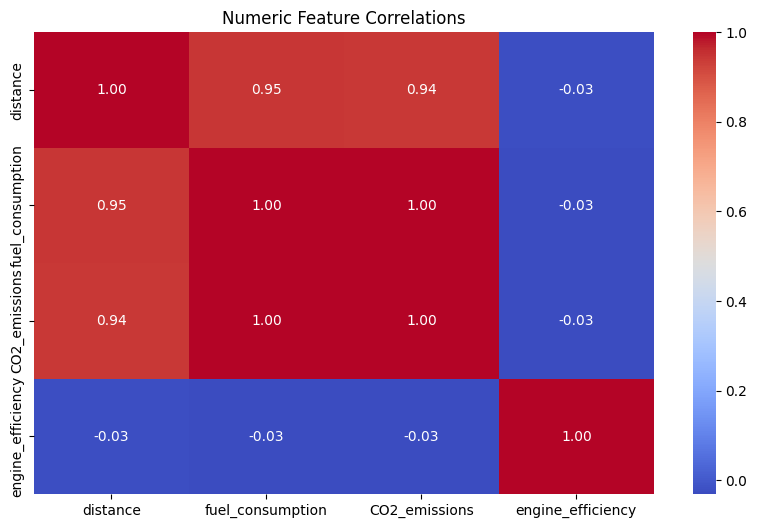

In [23]:
# histogram of efficiency_class
fig = px.histogram(df, x='efficiency_class', title='Efficiency Class Distribution')
fig.show()

# numeric correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric Feature Correlations')
plt.show()

# a scatter example: distance vs fuel_consumption
fig2 = px.scatter(df, x='distance', y='fuel_consumption', color='efficiency_class',
                  title='Distance vs Fuel Consumption (colored by efficiency class)')
fig2.show()

In [24]:
import pickle

feature_cols = ['ship_id','ship_type','route_id','month','distance','fuel_type',
                'fuel_consumption','CO2_emissions','weather_conditions']
target_col = 'efficiency_class'

X = df[feature_cols].copy()
y = df[target_col].copy()

encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# encode target
target_encoder = LabelEncoder()
y_enc = target_encoder.fit_transform(y)

# Save encoders to files for later inference
with open('encoders.pkl', 'wb') as f:
    pickle.dump({'encoders': encoders, 'target_encoder': target_encoder, 'feature_cols': feature_cols}, f)

print("Encoders saved to encoders.pkl")

Encoders saved to encoders.pkl


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

model = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.5833

Classification Report:
              precision    recall  f1-score   support

   Efficient       0.00      0.00      0.00        56
 Inefficient       0.60      0.97      0.74       173
    Moderate       0.00      0.00      0.00        59

    accuracy                           0.58       288
   macro avg       0.20      0.32      0.25       288
weighted avg       0.36      0.58      0.44       288

Confusion Matrix:
[[  0  55   1]
 [  2 168   3]
 [  1  58   0]]


In [26]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Trained model saved to model.pkl")

Trained model saved to model.pkl


In [28]:
app_code = r"""
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

st.set_page_config(page_title="Ship Fuel Efficiency App", layout="wide")
st.title("🚢 Ship Fuel Efficiency Prediction App (Colab)")

# Load model and encoders
@st.cache_resource
def load_artifacts():
    with open('model.pkl','rb') as f:
        model = pickle.load(f)
    with open('encoders.pkl','rb') as f:
        enc_data = pickle.load(f)
    return model, enc_data

model, enc_data = load_artifacts()
encoders = enc_data['encoders']
target_encoder = enc_data['target_encoder']
feature_cols = enc_data['feature_cols']

st.sidebar.header("Upload dataset (optional)")
uploaded = st.sidebar.file_uploader("CSV", type=['csv'])
if uploaded:
    df = pd.read_csv(uploaded)
    st.subheader("Dataset preview")
    st.dataframe(df.head())
else:
    st.info("No dataset uploaded. Use live prediction form below or upload a CSV in the sidebar.")
    df = None

# Live prediction form
st.header("🧮 Predict Efficiency for New Trip")

col1, col2 = st.columns(2)
with col1:
    ship_id = st.text_input("Ship ID", value="NG001")
    ship_type = st.text_input("Ship Type", value="Oil Service Boat")
    route_id = st.text_input("Route ID", value="Warri-Bonny")
    month = st.selectbox("Month", options=["January","February","March","April","May","June","July","August","September","October","November","December"])
with col2:
    distance = st.number_input("Distance", min_value=0.0, value=100.0)
    fuel_type = st.selectbox("Fuel Type", options=["HFO","Diesel"])
    fuel_consumption = st.number_input("Fuel Consumption", min_value=0.0, value=2000.0)
    CO2_emissions = st.number_input("CO2 Emissions", min_value=0.0, value=6000.0)
    weather_conditions = st.selectbox("Weather Conditions", options=["Calm","Moderate","Stormy"])

if st.button("Predict Efficiency"):
    input_df = pd.DataFrame([[ship_id, ship_type, route_id, month, distance, fuel_type, fuel_consumption, CO2_emissions, weather_conditions]],
                            columns=feature_cols)
    # encode categorical inputs using saved encoders
    for col, le in encoders.items():
        # If unseen category appears, handle it by adding a fallback mapping
        val = str(input_df.at[0, col])
        if val in le.classes_:
            input_df[col] = le.transform([val])
        else:
            # map unknown to a new label: append then transform (temporary)
            classes = list(le.classes_) + [val]
            new_le = type(le)()
            new_le.classes_ = np.array(classes)
            input_df[col] = new_le.transform([val])
    # ensure numeric columns are correct dtype
    input_df[['distance','fuel_consumption','CO2_emissions']] = input_df[['distance','fuel_consumption','CO2_emissions']].astype(float)
    # predict
    pred = model.predict(input_df)
    label = target_encoder.inverse_transform(pred)[0]
    st.success(f"Predicted Efficiency Class: **{label}**")

# If a dataset was uploaded, show model metrics computed on it (optional)
if df is not None:
    st.header("Dataset Prediction & Metrics (if dataset has engine_efficiency)")
    # prepare the same way as training pipeline if needed...
    st.write("This section can be used to batch predict and show dataset-level metrics.")
"""
with open('app.py', 'w') as f:
    f.write(app_code)

print("app.py written to disk.")

app.py written to disk.


In [36]:
# open http://localhost:8501

In [37]:
!pip install streamlit pandas scikit-learn plotly seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.1 MB/s eta 0:00:00
